<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/KaggleHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
df  = pd.read_csv('/content/train.csv')
def pre_porcess(df):
  df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis = 1,inplace = True)
  val = ['OverallQual','OverallCond','YearBuilt','LotArea','SaleCondition','GarageCars','GarageArea','GarageQual','MSSubClass','LotArea','Neighborhood']
  lk = df[val]
  lk.GarageQual = lk.GarageQual.fillna('TA')
  di = ['SaleCondition','GarageQual','Neighborhood']
  for val in di:
    one_hot = pd.get_dummies(lk[val])
    lk = lk.drop(val,axis = 1)
    lk = lk.join(one_hot.iloc[:,1:])
  return lk 
Y = df.SalePrice

In [ ]:
lk = pre_porcess(df)


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X = lk.values

In [ ]:
X = scaler.fit_transform(X)

In [ ]:
X.shape

(1460, 41)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y.values,random_state = 42,test_size = 0.2)

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [ ]:
X_train = torch.from_numpy(x_train.astype(np.float32)).to(device)
Y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
X_test = torch.from_numpy(x_test.astype(np.float32)).to(device)
Y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

In [ ]:
class Model(nn.Module):
  def __init__(self,input_layer = 41,hidden_units = 64,output_dim = 1):
    super(Model,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(input_layer,hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units,hidden_units*2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_units*2,hidden_units*4),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(hidden_units*4,1)
    )

  def forward(self,x):
    return self.model(x)

In [ ]:
loss_fn = nn.MSELoss()
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4 * 2)

In [ ]:
n_epochs = 400
batch_size = 32
train_losses = []
test_losses = []
for ep in range(n_epochs):
  permutation = torch.randperm(X_train.size()[0])
  train_loss = []
  for i in range(0,X_train.size()[0], batch_size):
    optimizer.zero_grad()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], Y_train[indices]
    outputs = model(batch_x).squeeze()
    loss = loss_fn(outputs,batch_y)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  train_loss = np.mean(train_loss)

  permutation_test = torch.randperm(X_test.size()[0])
  test_loss = []
  for i in range(0,X_test.size()[0], batch_size):
    indices_test = permutation_test[i:i+batch_size]
    batch_x_test, batch_y_test = X_test[indices_test], Y_test[indices_test]
    outputs = model(batch_x_test).squeeze()
    loss = loss_fn(outputs,batch_y_test)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

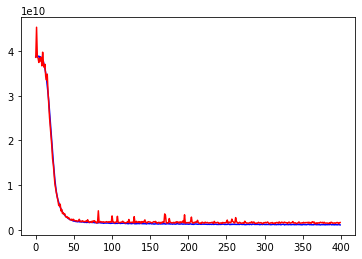

In [ ]:
plt.plot(train_losses,color = 'b')
plt.plot(test_losses,color = 'r')
plt.show()

In [ ]:
test_df = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
test_d = pre_porcess(test_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
test_d = scaler.fit_transform(test_d)
test_d = torch.from_numpy(test_d.astype(np.float32)).to(device)

In [ ]:
ID = sub.Id

In [ ]:
X_VAl = sub.iloc[:,1:].values 

In [ ]:
with torch.no_grad():
  pred = model(test_d)

In [ ]:
pred = np.array(pred.cpu())

In [ ]:
pred,sub =  pred.squeeze(),X_VAl.squeeze()

In [ ]:
res = pd.concat([ID,res_temp],axis =1)
res.head(5)

,Id,SalePrice
0,1461,89611.578125
1,1462,104646.359375
2,1463,144048.703125
3,1464,170482.171875
4,1465,213582.531250


In [ ]:
res.to_csv('./submission.csv', index=True)

In [ ]:
n_correct = 0
n_total = sub.shape[0]
for i in range(n_total):
  if pred[i] == sub[i]:
    n_correct += 1

print(f'Accuracy {n_correct/n_total}')

Accuracy 0.0
